In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from livelossplot.tf_keras import PlotLossesCallback

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
tf.__version__

'2.0.0-alpha0'

## Data

We are looking at a bunch of fashion images with the following labels:

In [10]:
labels = "T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot".split(", ")

Keras already has this dataset built in, but normally there would be a whole step of finding, downloading, unzipping files, reading files...

In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Eyeballing the images:

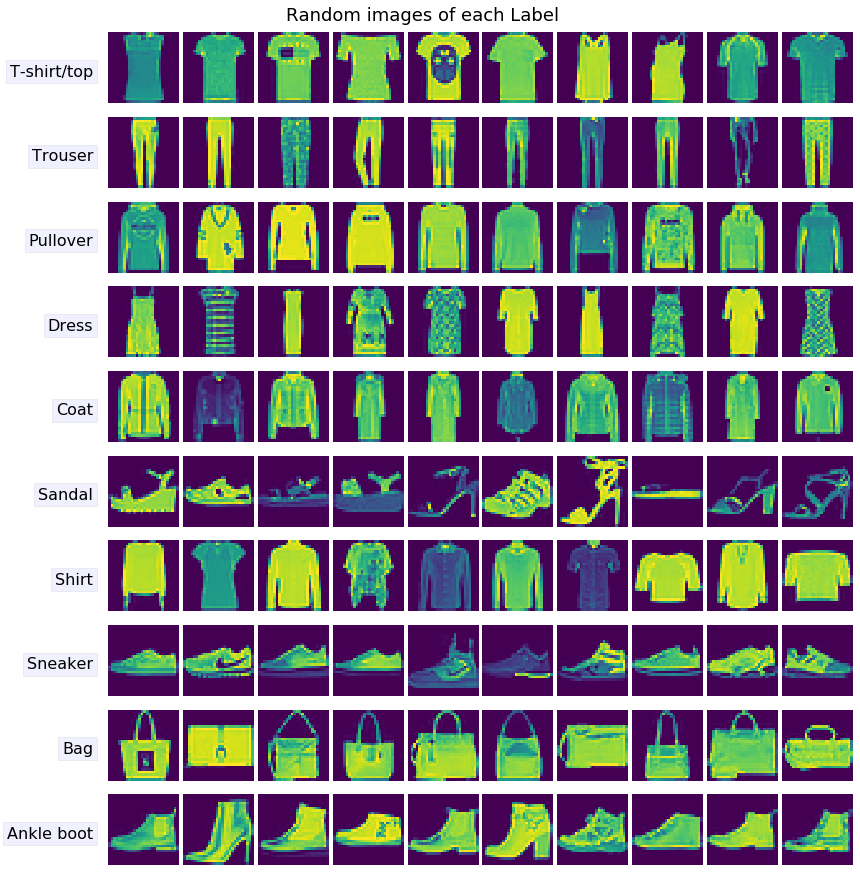

In [24]:
fig, axes = plt.subplots(len(labels),11, figsize=(12,12), sharey=True, sharex=True)

for i, label in enumerate(labels):
    ma = y_train[:,i] == 1 # mask for each label
    for j in range(0, 11):
        ax = axes[i,j]
        if j == 0: # label the first subplot
            ax.text(0.85, 0.4, label, fontsize=16, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    bbox=dict(facecolor='blue', alpha=0.06))
        else: 
            idx = np.random.randint(0, x_train[ma].shape[0])
            ax.imshow(x_train[ma][idx][:,:,0], cmap=None) #try gray, hot
        ax.axis("off")
plt.tight_layout(pad=0)
fig.suptitle(y=1.02, t='Random images of each Label', fontsize=18);

## Preprocess

I'm doing a basic preprocessing of the images, though ideally I can add an image augmentation step as well, but leaving it for this simple example.

In [29]:
def preprocess(images):
    images = images.reshape(images.shape[0], 28, 28, 1) # cause keras wants 3 channels
    images = images.astype('float32') # everyone likes floats
    images /= 255 # normalizing to b/w 0 and 1
    return images

# process the images
x_train, x_test = preprocess(x_train), preprocess(x_test)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

Now I'm classifying this using a basic CNN network built in Keras.

This [paper](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) clarifies that using dropout at 0.2-0.3 improves accuracy for CNN networks.

In [30]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

# added another dropout layer for testing to see what it does
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

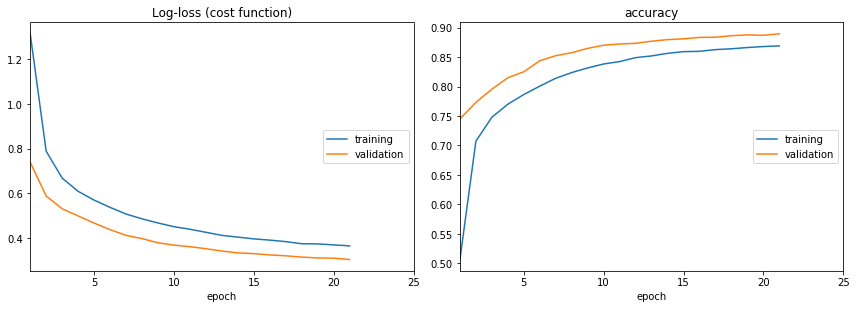

Log-loss (cost function):
training   (min:    0.365, max:    1.314, cur:    0.365)
validation (min:    0.304, max:    0.739, cur:    0.304)

accuracy:
training   (min:    0.506, max:    0.869, cur:    0.869)
validation (min:    0.745, max:    0.890, cur:    0.890)


In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=25, 
                    batch_size=64,
                    callbacks=[PlotLossesCallback(), keras.callbacks.EarlyStopping()],
                    verbose=0)

In [ ]:
model.evaluate(x_test, y_test)

In [23]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 239us/sample - loss: 0.3181 - accuracy: 0.8839


[0.318070503616333, 0.8839]

That performed ok, though > 90% would be decent and around 95% good.

Explore further:

- data augmentation - for images this is pretty straightforward, but for other data types it would get tricker?
- how many dense layers is ideal? It seems standard practice is to flatten out the last conv layer, add one dense layer than a final dense layer which does the softmax classification.